## 1. 导入库函数

In [2]:
# 获取当前的目录，获取上一级的目录
import sys,os
from pathlib import Path
curr_path = str(Path().absolute())
parent_path = str(Path().absolute().parent)
sys.path.append(parent_path)  # add current terminal path to sys.path
# 导入时间
import datetime
curr_time = datetime.datetime.now().strftime(
    "%Y%m%d-%H%M%S")  # obtain current time
# 导入相应的函数
import gym
import math
import numpy as np
from collections import defaultdict
import torch
from utils import save_results,make_dir
from utils import plot_rewards
from envs.gridworld_env import CliffWalkingWapper
from agents.QLearning import QLearning

## 2. 初始化Agent和Environment

In [6]:
# config
class QLearning_config:
    def __init__(self):
        self.algo = "QLearning" # 算法
        self.env = "CliffWalking-v0" #环境
        self.gamma = 0.9 # reward的衰减率
        self.train_eps = 400 # 训练的回合数
        self.test_eps = 20 # 测试的回合数
        self.epsilon_start = 0.95 # e-greedy策略中初始epsilon
        self.epsilon_end = 0.01 # e-greedy策略中的终止epsilon
        self.epsilon_decay = 300 # e-greedy策略中epsilon的衰减率
        self.lr = 0.1 # 学习率
        self.result_path = curr_path+"/outputs/" + self.env + \
            '/'+curr_time+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" + self.env + \
            '/'+curr_time+'/models/'  # path to save models
        self.device = torch.device( # 检测GPU
            "cuda" if torch.cuda.is_available() else "cpu")  # check gpu
        self.save = True

# 生成agent和environment
def env_agent_config(cfg,seed=1):
    env = gym.make(cfg.env)  
    env = CliffWalkingWapper(env)
    # env.seed(seed) # 设置随机种子
    state_dim = env.observation_space.n # 状态维度
    action_dim = env.action_space.n # 动作维度
    agent = QLearning(state_dim,action_dim,cfg)
    return env,agent

cfg = QLearning_config()
env,agent = env_agent_config(cfg,seed=1)

## 3. 训练模型并画图

In [7]:
def train(cfg,env,agent):
    print('Start training!')
    print(f'Env: {cfg.env}, Algorithm: {cfg.algo}, Device: {cfg.device}')
    rewards = []  # 记录奖励
    ma_rewards = [] # 记录滑动平均奖励
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录每个episode的reward
        state = env.reset()  # 重置环境, 重新开一局（即开始新的一个episode）
        while True:
            action = agent.choose_action(state)  # 根据算法选择一个动作
            next_state, reward, done, _ = env.step(action)  # 与环境进行一次动作交互
            agent.update(state, action, reward, next_state, done)  # Q-learning算法更新
            state = next_state  # 存储上一个观察值
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1]*0.9+ep_reward*0.1)
        else:
            ma_rewards.append(ep_reward)
        if (i_ep+1)%20 == 0: 
            print('Episode: {}/{}, Reward: {}'.format(i_ep+1, cfg.train_eps, ep_reward))
    print('Completing training!')
    return rewards,ma_rewards

rewards, ma_rewards = train(cfg, env, agent)
# 保存模型和训练结果信息
make_dir(cfg.result_path, cfg.model_path)
save_results(rewards, ma_rewards, tag='train', path=cfg.result_path)
agent.save(path=cfg.model_path)
plot_rewards(rewards, ma_rewards,cfg, tag="train")

Start training!
Env: CliffWalking-v0, Algorithm: QLearning, Device: cpu


/Users/jayx/miniforge3/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


ValueError: too many values to unpack (expected 4)

## 4. 测试模型并画图

加载模型成功！
Start Testing!
Env: CliffWalking-v0, Algorithm: QLearning, Device: cpu
Episode: 1/20, Reward: -13.0
Episode: 2/20, Reward: -13.0
Episode: 3/20, Reward: -13.0
Episode: 4/20, Reward: -13.0
Episode: 5/20, Reward: -13.0
Episode: 6/20, Reward: -13.0
Episode: 7/20, Reward: -13.0
Episode: 8/20, Reward: -13.0
Episode: 9/20, Reward: -13.0
Episode: 10/20, Reward: -13.0
Episode: 11/20, Reward: -13.0
Episode: 12/20, Reward: -13.0
Episode: 13/20, Reward: -13.0
Episode: 14/20, Reward: -13.0
Episode: 15/20, Reward: -13.0
Episode: 16/20, Reward: -13.0
Episode: 17/20, Reward: -13.0
Episode: 18/20, Reward: -13.0
Episode: 19/20, Reward: -13.0
Episode: 20/20, Reward: -13.0
Complete Testing!
结果保存完毕！


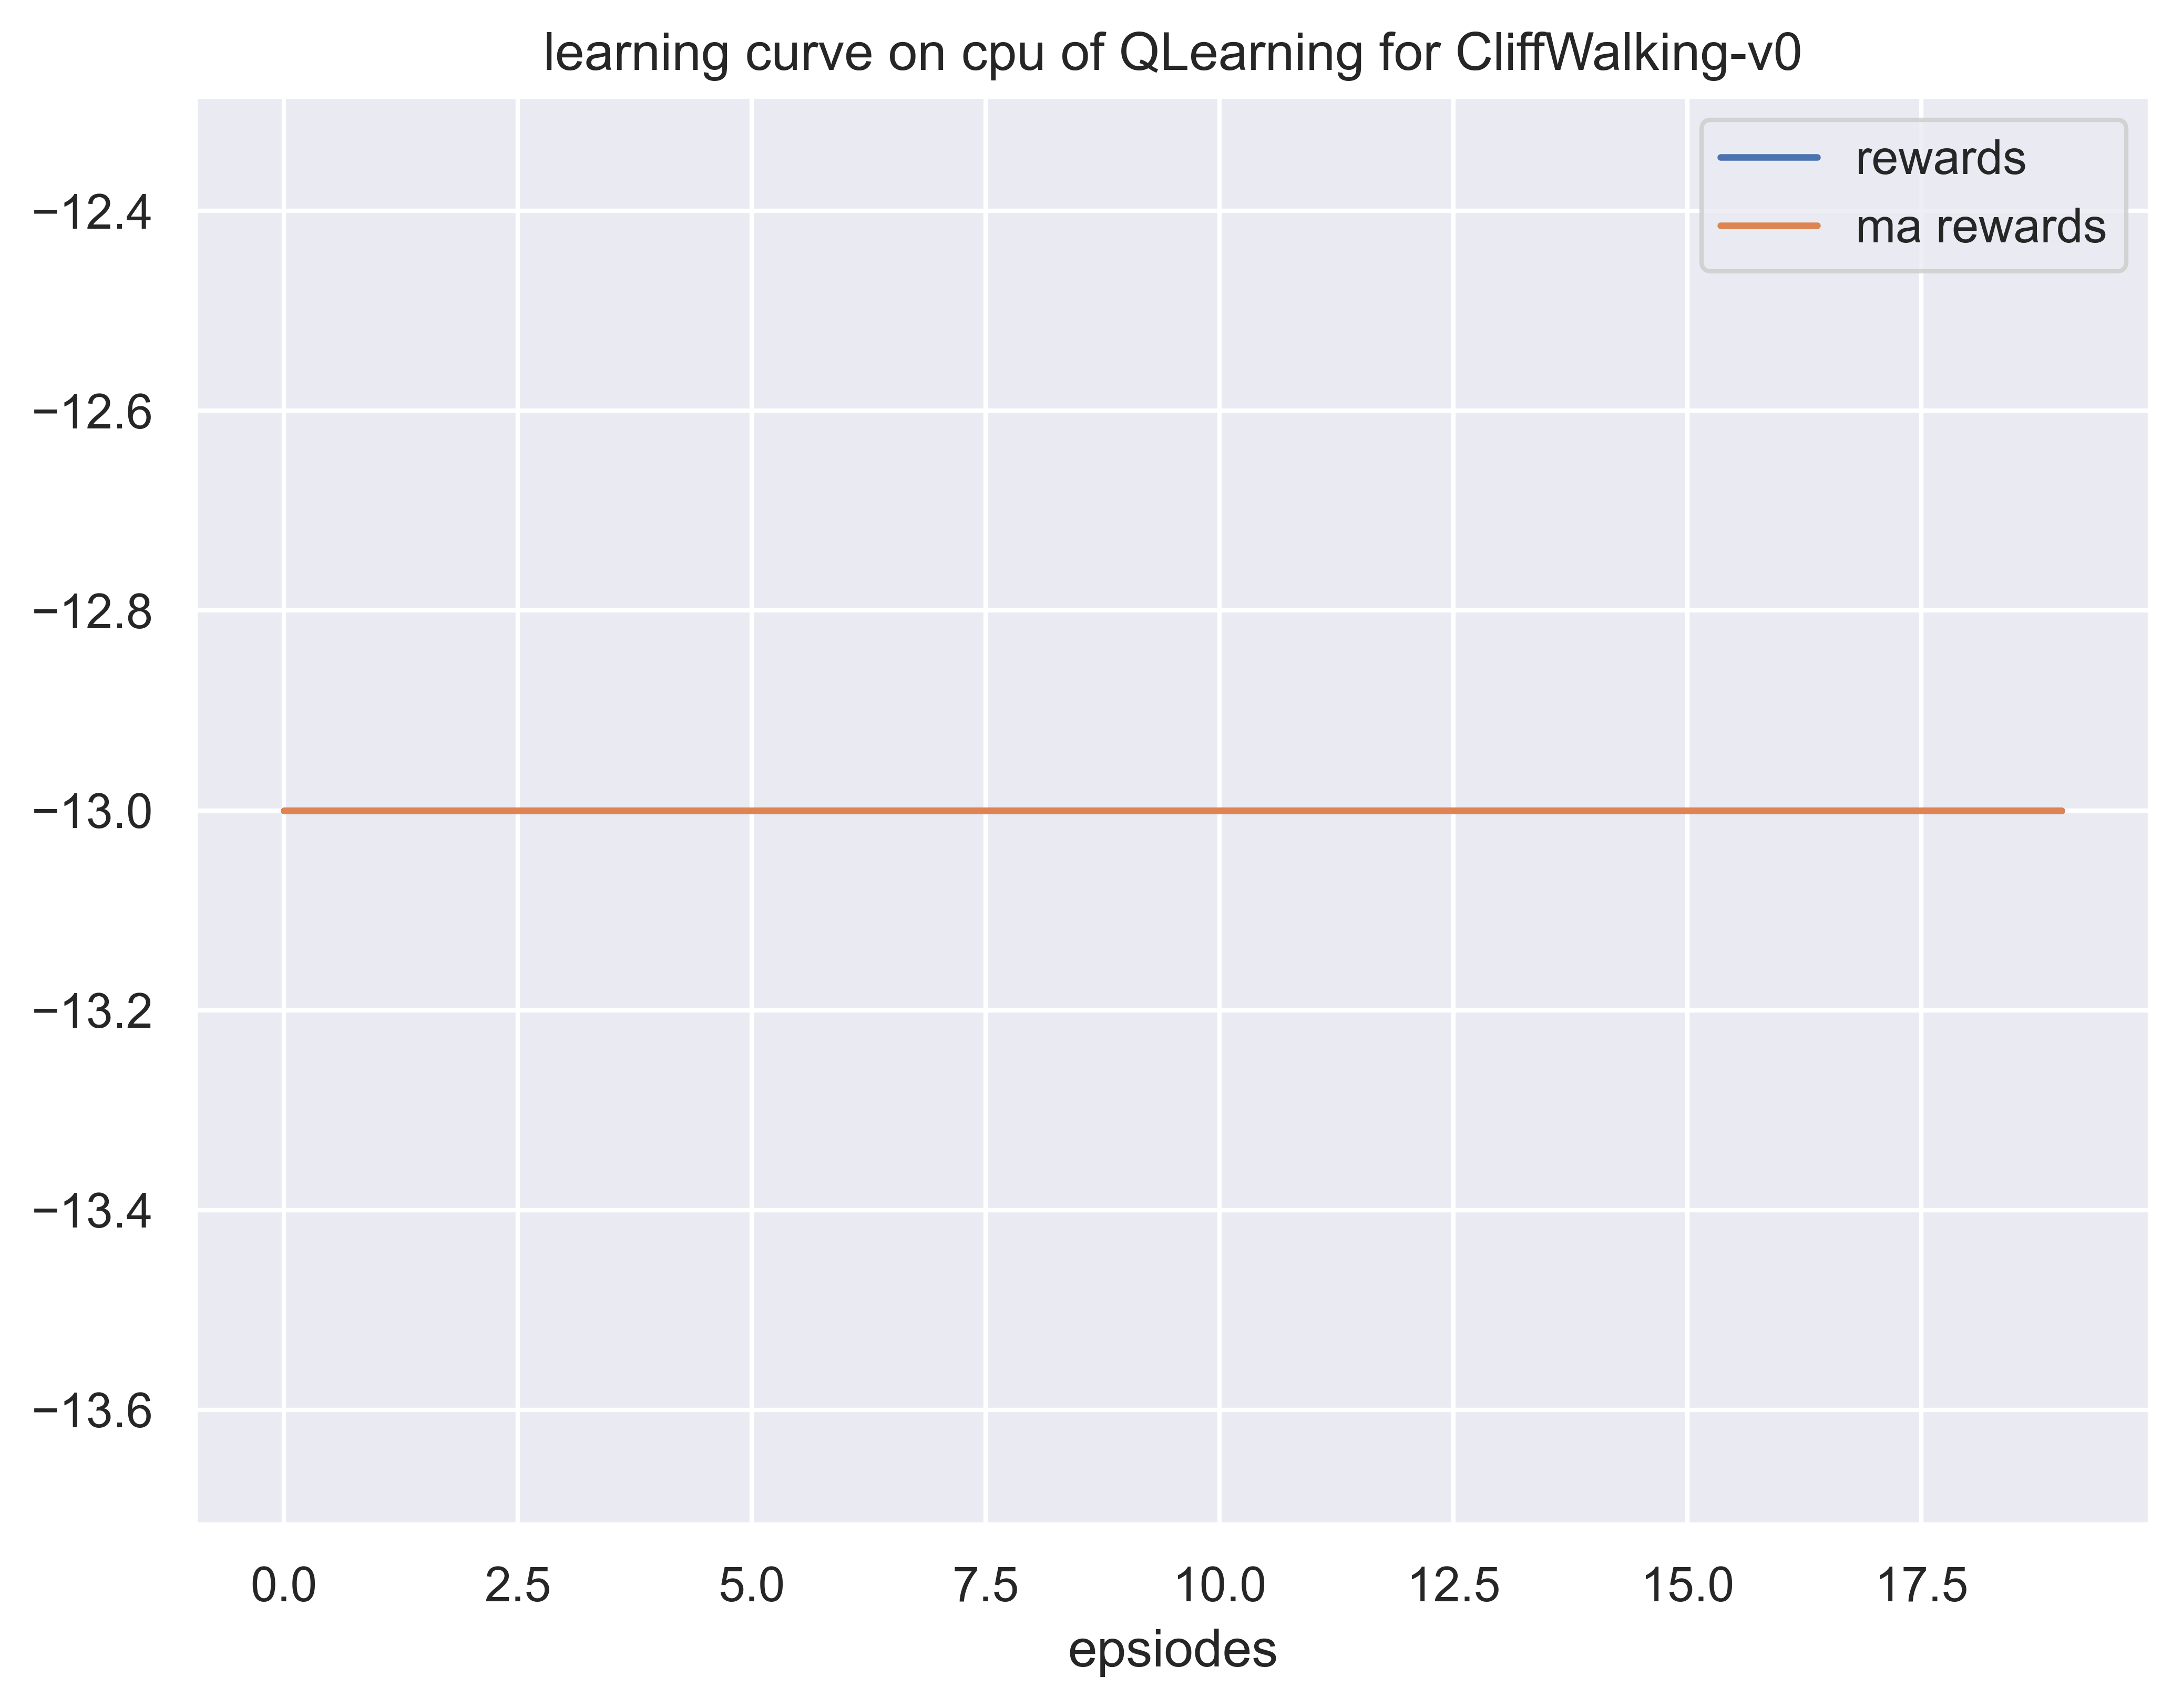

In [ ]:
def test(cfg,env,agent):
    # env = gym.make("FrozenLake-v0", is_slippery=False)  # 0 left, 1 down, 2 right, 3 up
    # env = FrozenLakeWapper(env)
    print('Start Testing!')
    print(f'Env: {cfg.env}, Algorithm: {cfg.algo}, Device: {cfg.device}')
    # 由于测试不需要使用epsilon-greedy策略，所以相应的值设置为0
    cfg.epsilon_start = 0.0 # e-greedy策略中初始epsilon
    cfg.epsilon_end = 0.0 # e-greedy策略中的终止epsilon
    rewards = [] # 记录所有回合的奖励
    ma_rewards = []  # 记录所有回合的滑动平均奖励
    rewards = []  # 记录所有episode的reward
    ma_rewards = [] # 滑动平均的reward
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录每个episode的reward
        state = env.reset()  # 重置环境, 重新开一局（即开始新的一个episode）
        while True:
            action = agent.predict(state)  # 根据算法选择一个动作
            next_state, reward, done, _ = env.step(action)  # 与环境进行一个交互
            state = next_state  # 存储上一个观察值
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1]*0.9+ep_reward*0.1)
        else:
            ma_rewards.append(ep_reward)
        print(f"Episode: {i_ep+1}/{cfg.test_eps}, Reward: {ep_reward:.1f}")
    print('Complete Testing!')
    return rewards,ma_rewards

env, agent = env_agent_config(cfg, seed=10)
agent.load(path=cfg.model_path)  # 导入模型
rewards, ma_rewards = test(cfg, env, agent) # 测试
save_results(rewards, ma_rewards, tag='test', path=cfg.result_path)  # 保存结果
plot_rewards_mine(rewards, ma_rewards, cfg, tag="test")  # 画出结果